In [96]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../python')
from functions import *
from models import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

save_folder = "gd1_tail"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [90]:
df = pd.read_hdf('../gaia_data/gd1/gaiascan_l99.0_b50.2_ra224.7_dec60.6.h5')

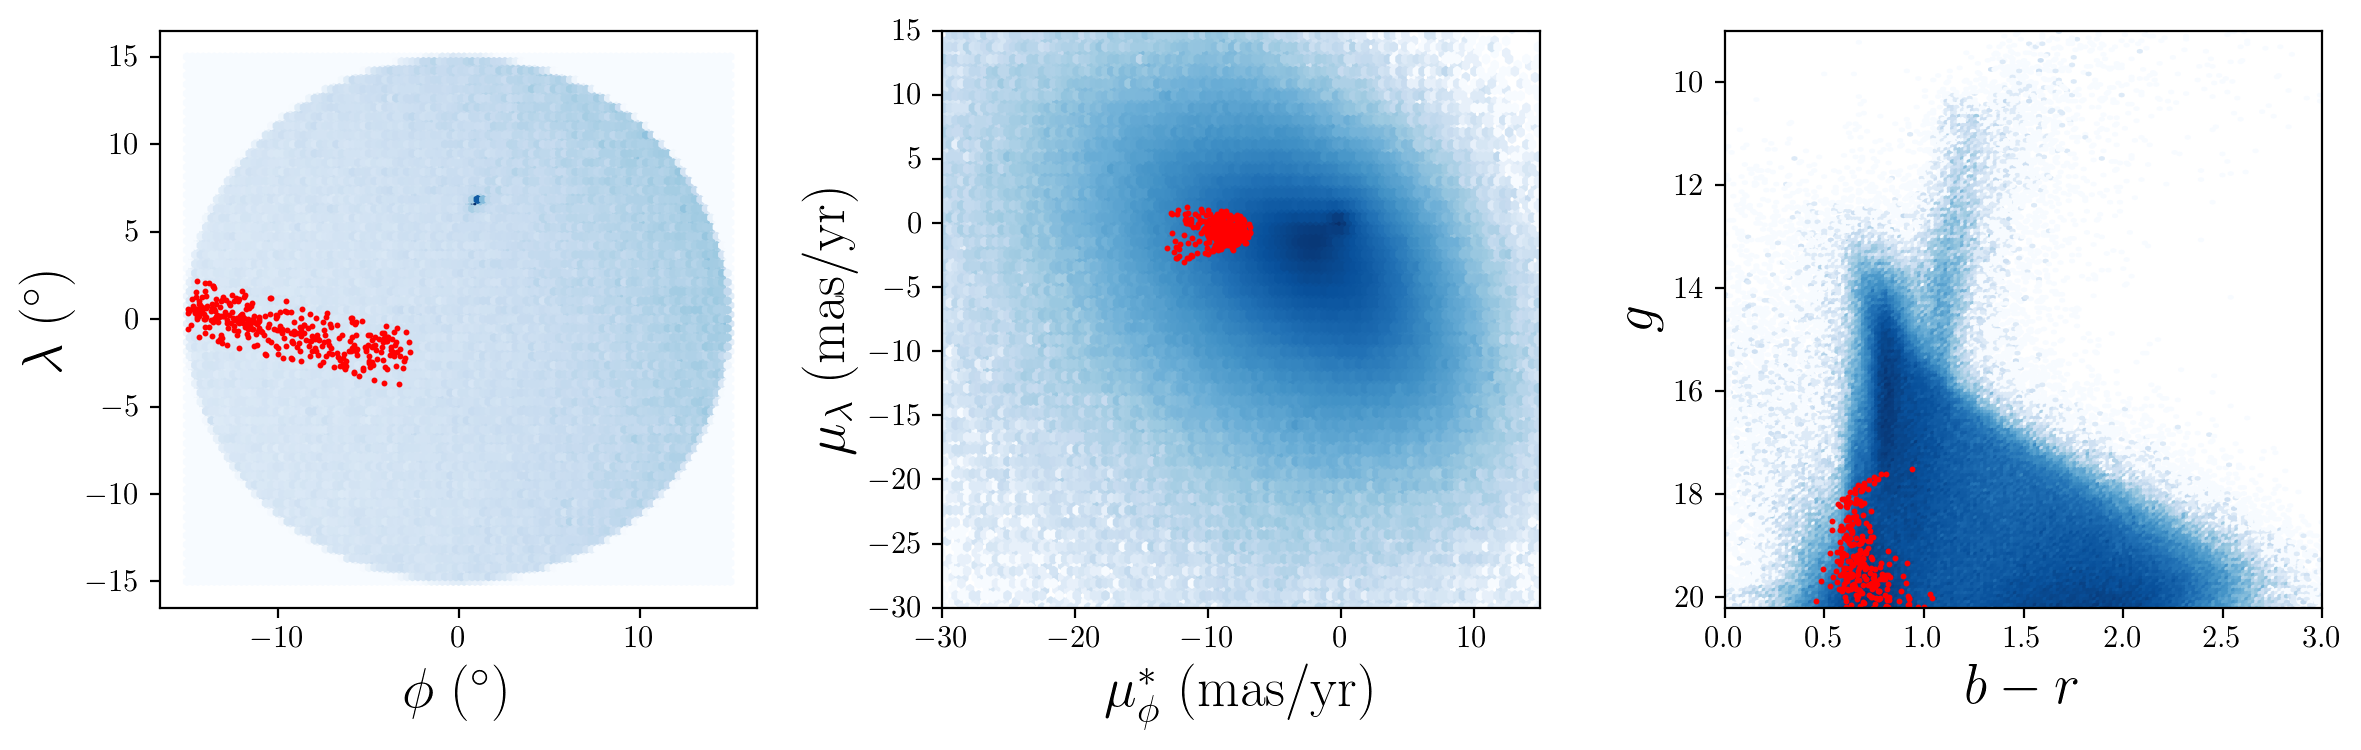

In [91]:
make_plots(df)

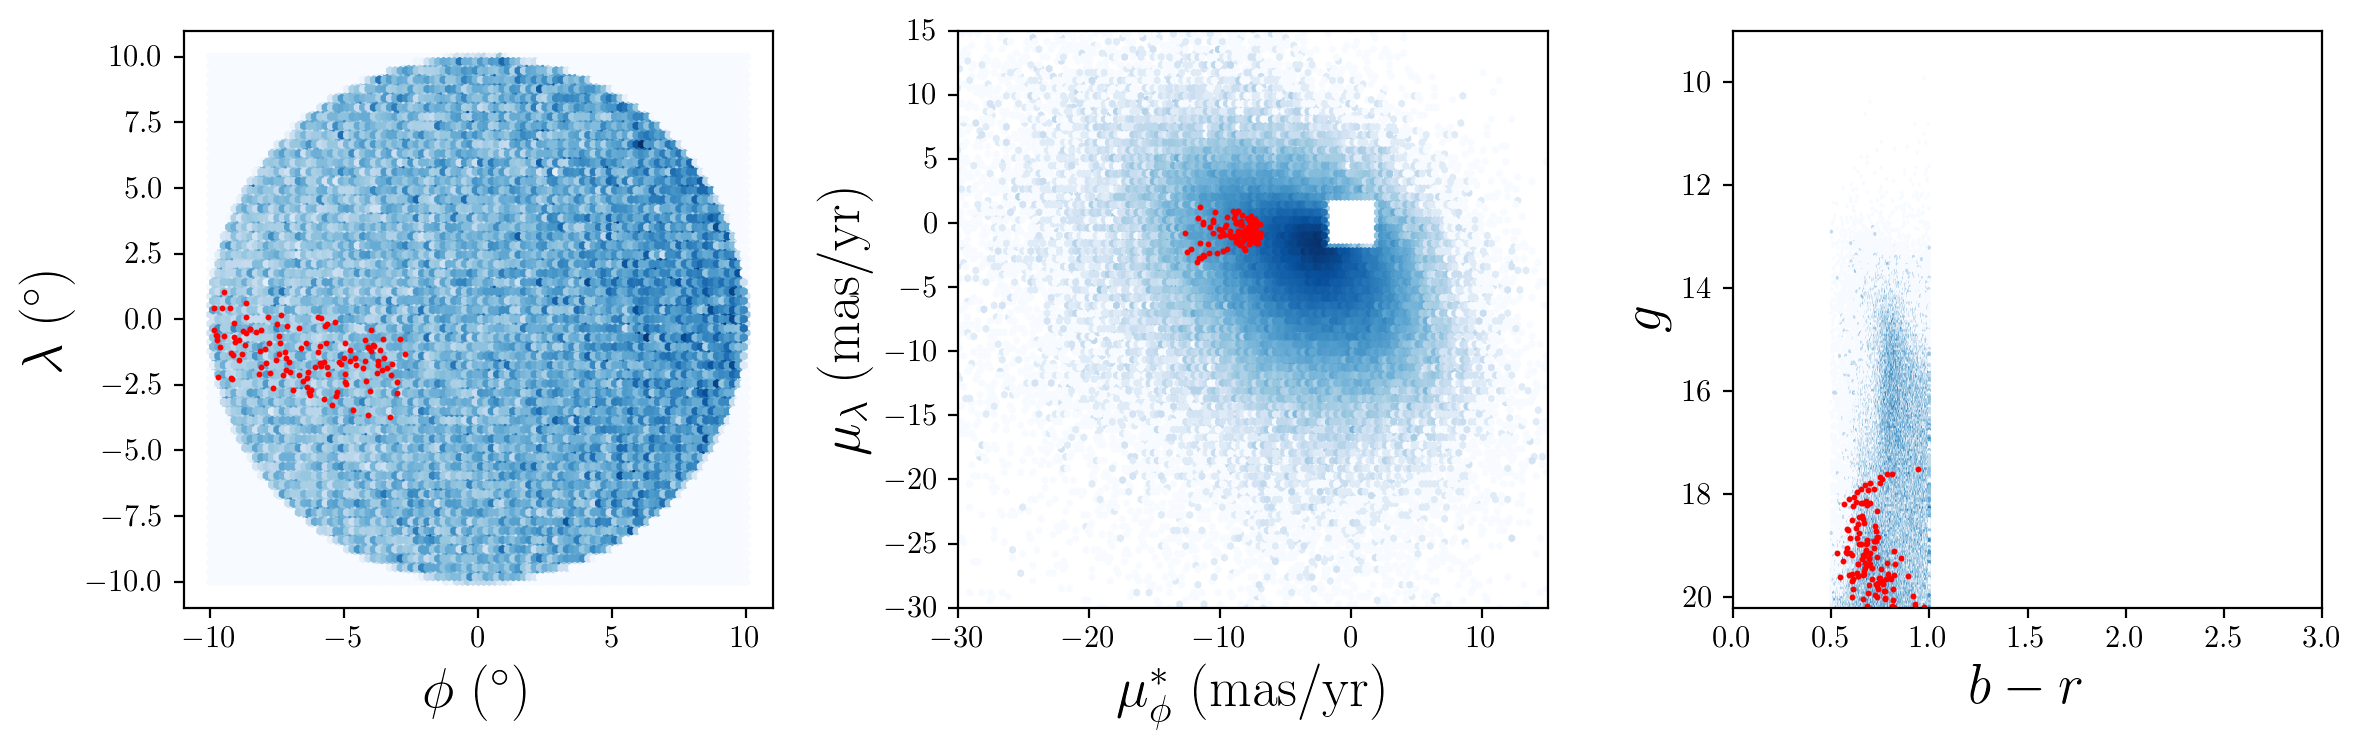

In [92]:
make_plots(fiducial_cuts(df))

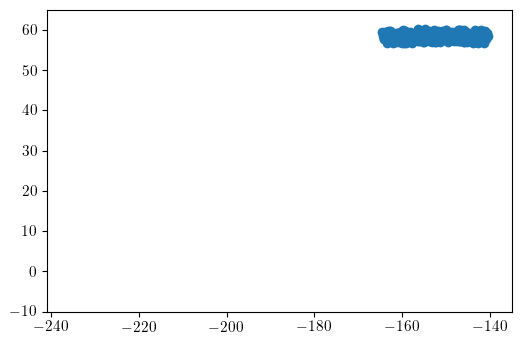

In [94]:
plt.scatter(df[df.stream].α_wrapped-360, df[df.stream].δ)
plt.xlim(-241,-135);
plt.ylim(-10,65);

SR factor: 2
SB factor: 3
Sideband region: [-3.1,-2.3) & (0.9,1.7]
Signal region: [-2.3,0.9]
Total counts: SR = 398,621, SB = 158,472
Signal region has 321 stream and 398,300 bkg events (0.08%).
Sideband region has 336 stream and 556,757 bkg events (0.06%).
f_sig = 1.3X f_sideband.


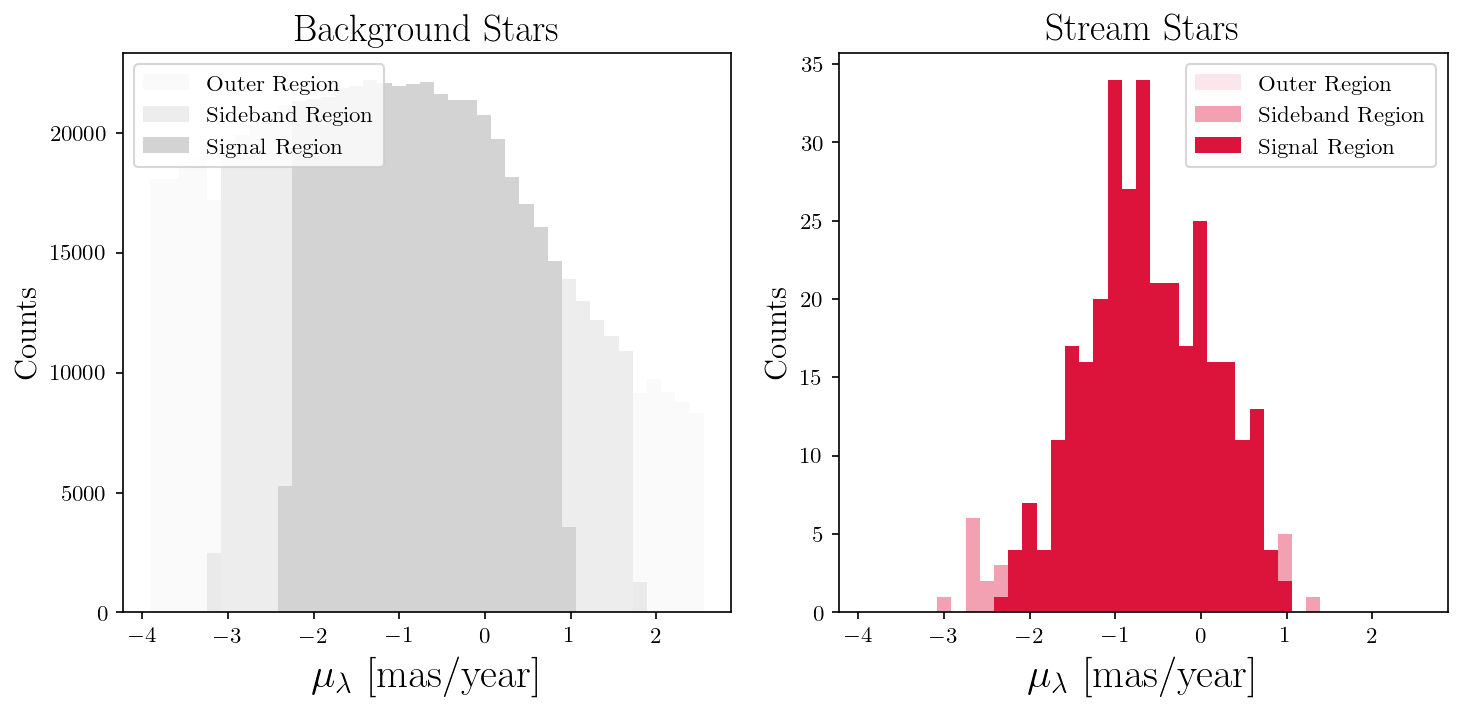

In [99]:
sr_factor = 2
sb_factor = 3
df_slice = signal_sideband(df, sr_factor = sr_factor, sb_factor=sb_factor, save_folder = save_folder)

# Train

[Step 2] Validation set (x3):   0%|          | 0/4 [00:00<?, ?it/s]

3482/3482 [==============================] - 5s 1ms/step



[Step 2] Validation set (x3):  25%|██▌       | 1/4 [01:03<03:09, 63.11s/it]

3482/3482 [==============================] - 3s 786us/step



[Step 2] Validation set (x3):  50%|█████     | 2/4 [02:03<02:03, 61.60s/it]

3482/3482 [==============================] - 4s 1ms/step



[Step 2] Validation set (x3):  75%|███████▌  | 3/4 [03:02<01:00, 60.24s/it]

3482/3482 [==============================] - 4s 1ms/step



[Step 2] Validation set (x3): 100%|██████████| 4/4 [04:02<00:00, 60.74s/it]


Plotting results before fiducial cuts...
Plotting results after fiducial cuts...


[Step 2] Validation set (x3):   0%|          | 0/4 [00:00<?, ?it/s]

3482/3482 [==============================] - 4s 1ms/step



[Step 2] Validation set (x3):  25%|██▌       | 1/4 [01:00<03:01, 60.57s/it]

3482/3482 [==============================] - 5s 1ms/step



[Step 2] Validation set (x3):  50%|█████     | 2/4 [01:59<01:59, 59.64s/it]

3482/3482 [==============================] - 5s 1ms/step



[Step 2] Validation set (x3):  75%|███████▌  | 3/4 [02:59<00:59, 59.90s/it]

3482/3482 [==============================] - 3s 806us/step



[Step 2] Validation set (x3): 100%|██████████| 4/4 [04:02<00:00, 60.72s/it]


Plotting results before fiducial cuts...
Plotting results after fiducial cuts...


[Step 2] Validation set (x3):   0%|          | 0/4 [00:00<?, ?it/s]

3482/3482 [==============================] - 5s 1ms/step



[Step 2] Validation set (x3):  25%|██▌       | 1/4 [01:02<03:06, 62.06s/it]

3482/3482 [==============================] - 5s 1ms/step



[Step 2] Validation set (x3):  50%|█████     | 2/4 [02:04<02:05, 62.56s/it]

3482/3482 [==============================] - 5s 1ms/step



[Step 2] Validation set (x3):  75%|███████▌  | 3/4 [03:07<01:02, 62.40s/it]

3482/3482 [==============================] - 3s 787us/step



[Step 2] Validation set (x3): 100%|██████████| 4/4 [04:05<00:00, 61.36s/it]


Plotting results before fiducial cuts...
Plotting results after fiducial cuts...


[Step 2] Validation set (x3):   0%|          | 0/4 [00:00<?, ?it/s]

3482/3482 [==============================] - 5s 1ms/step



[Step 2] Validation set (x3):  25%|██▌       | 1/4 [01:00<03:00, 60.15s/it]

3482/3482 [==============================] - 3s 941us/step



[Step 2] Validation set (x3):  50%|█████     | 2/4 [01:59<01:59, 59.62s/it]

3482/3482 [==============================] - 5s 1ms/step



[Step 2] Validation set (x3):  75%|███████▌  | 3/4 [02:58<00:59, 59.36s/it]

3482/3482 [==============================] - 5s 1ms/step



[Step 2] Validation set (x3): 100%|██████████| 4/4 [03:57<00:00, 59.50s/it]


Plotting results before fiducial cuts...
Plotting results after fiducial cuts...


[Step 2] Validation set (x3):   0%|          | 0/4 [00:00<?, ?it/s]

3482/3482 [==============================] - 4s 1ms/step



[Step 2] Validation set (x3):  25%|██▌       | 1/4 [01:00<03:01, 60.61s/it]

3482/3482 [==============================] - 5s 1ms/step



[Step 2] Validation set (x3):  50%|█████     | 2/4 [02:00<02:00, 60.40s/it]

3482/3482 [==============================] - 5s 1ms/step



[Step 2] Validation set (x3):  75%|███████▌  | 3/4 [03:15<01:06, 66.75s/it]

3482/3482 [==============================] - 5s 1ms/step



[Step 2] Validation set (x3): 100%|██████████| 4/4 [04:18<00:00, 64.63s/it]


Plotting results before fiducial cuts...
Plotting results after fiducial cuts...


[Step 1] k-fold: 100%|██████████| 5/5 [20:40<00:00, 248.10s/it]


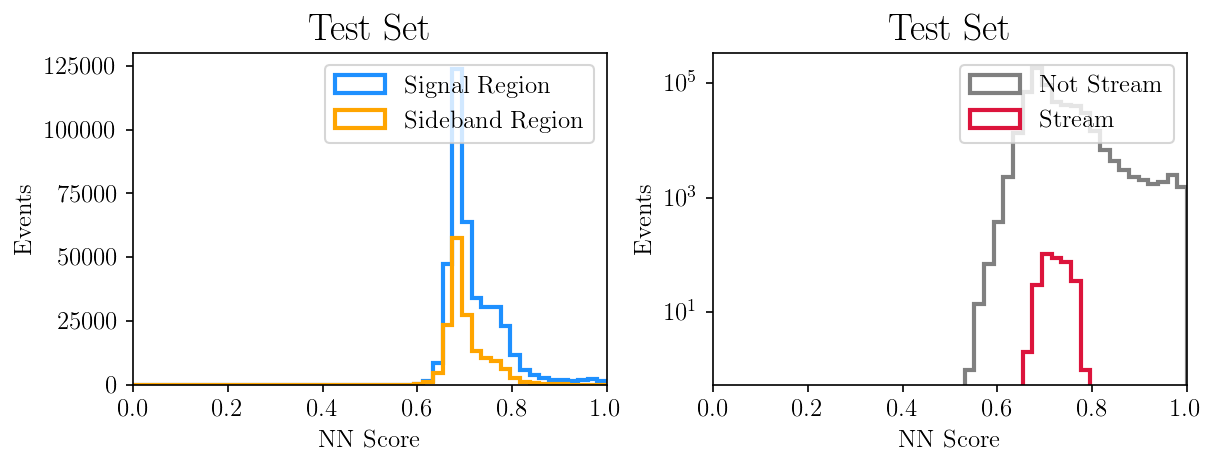

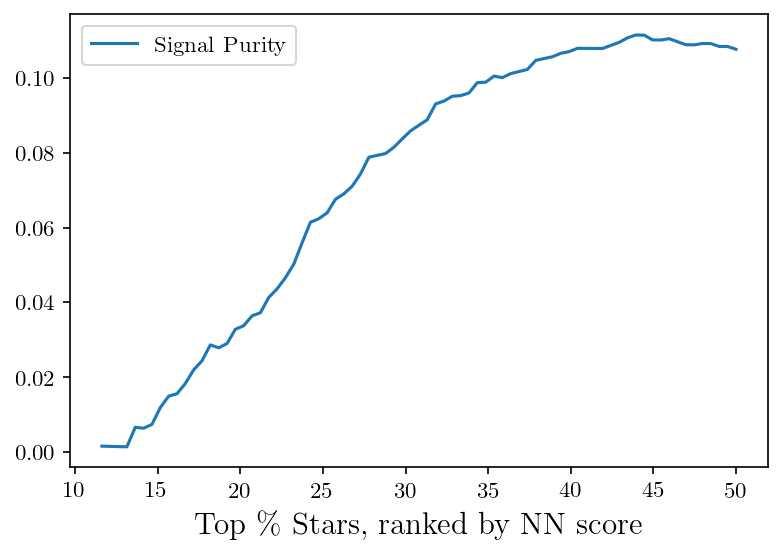

Top 50 stars: Purity = 0.0% 


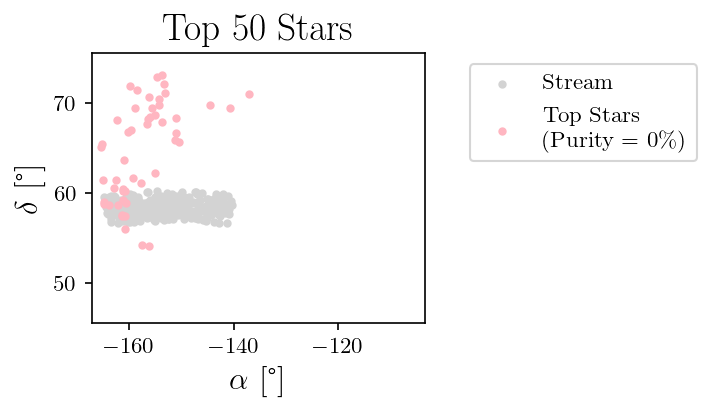

Top 100 stars: Purity = 0.0% 


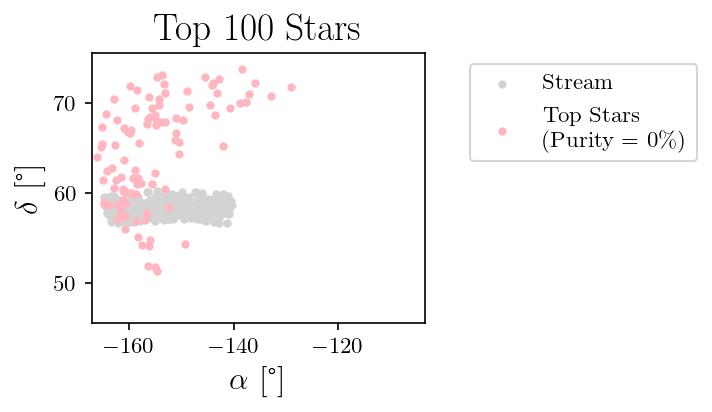

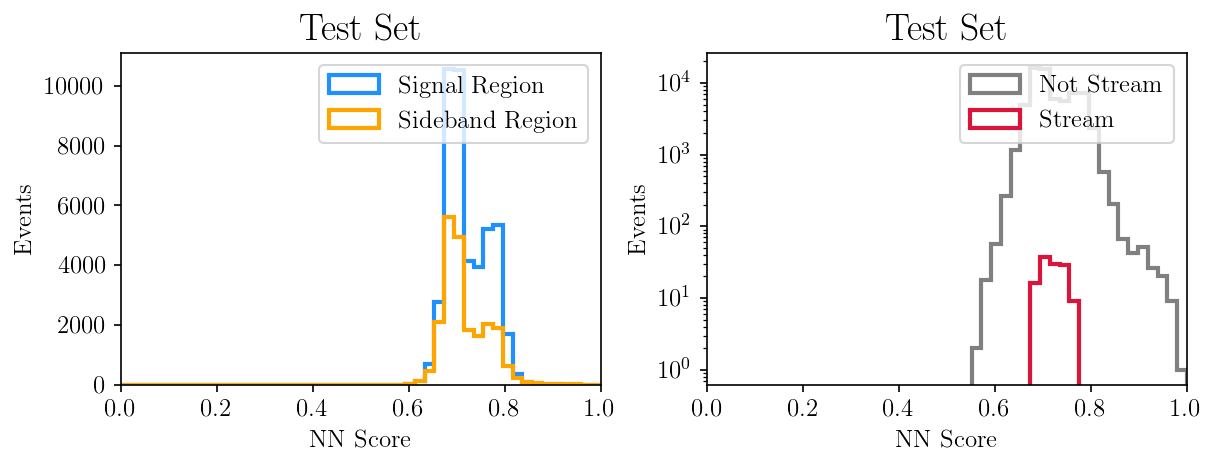

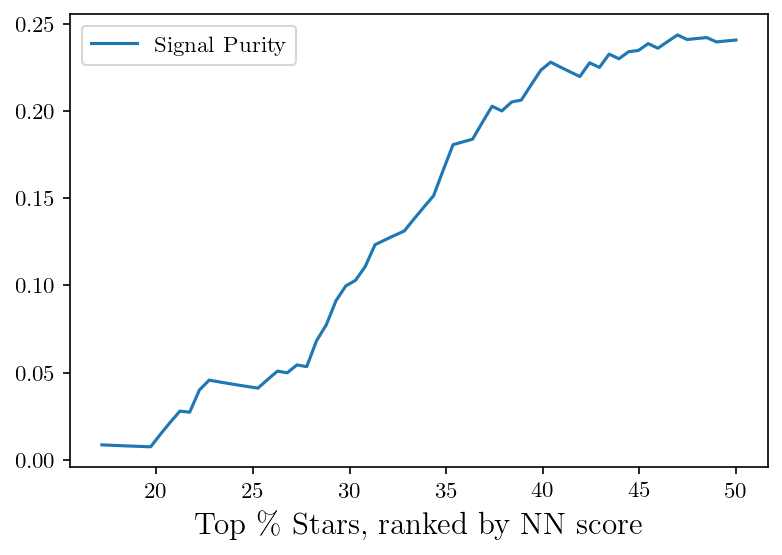

Top 50 stars: Purity = 0.0% 


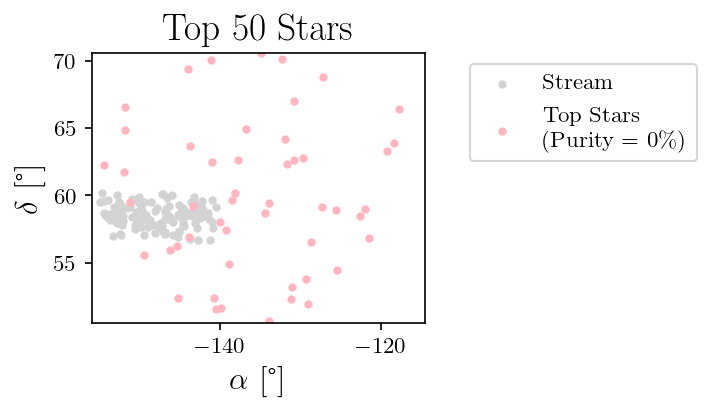

Top 100 stars: Purity = 0.0% 


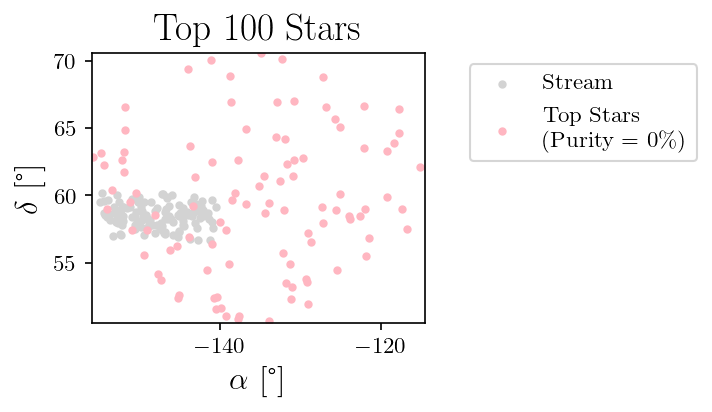

In [100]:
tf.keras.backend.clear_session()
df_test = train(df_slice, verbose = False, save_folder = save_folder)